In [82]:
import pandas as pd
import ast
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_paths = [
	'coarse_gs_results_giulia1.csv',
	'coarse_gs_results_giulia800_1.csv',
 	'coarse_gs_results_giulia800_2.csv',
 	'coarse_gs_results_giulia800_3.csv',
 	'coarse_gs_results_giulia800_4.csv',
	'coarse_gs_results_irene1.csv',
	'coarse_gs_results_irene2.csv',
	'coarse_gs_results_lorenzo1.csv',
 	'coarse_gs_results_lorenzo2.csv',
	'coarse_gs_results_lorenzo3.csv',
	'coarse_gs_results_lorenzo4.csv',
	'coarse_gs_results_lorenzo5.csv'
]
MEE = 'MEE'
MSE = 'MSE'
N_MODELS = 1656
K = 3

# concatenate results into a single dataframe
scores_df = pd.DataFrame(columns=[])
for path in results_paths:
	partial_scores_df = pd.read_csv(path, sep=",")
	scores_df = pd.concat([scores_df, partial_scores_df], ignore_index=True)

########### SWAP COLUMNS ##########

# NOTE: delete for the fine grid search!

# val_mee_mean <--> val_mse_mean
# val_mee_dev <--> val_mse_dev
# splitX_val_mee <--> split0_val_mse

scores_df = scores_df.rename(
	columns = {
	"val_mee_mean": "val_MSE_mean",
	"val_mee_dev": "val_MSE_dev",
	"split0_val_mee": "split0_val_MSE",
	"split1_val_mee": "split1_val_MSE",
	"split2_val_mee": "split2_val_MSE",
	"val_mse_mean" : "val_MEE_mean",
	"val_mse_dev" : "val_MEE_dev",
	"split0_val_mse" : "split0_val_MEE",
	"split1_val_mse" : "split1_val_MEE",
	"split2_val_mse" : "split2_val_MEE"
	}
)

###########################################

# rank results
scores_df['val_%s_mean_rank'%MEE] = rankdata(scores_df['val_%s_mean'%MEE], method='dense')
scores_df['val_%s_mean_rank'%MSE] = rankdata(scores_df['val_%s_mean'%MSE], method='dense')
scores_df['tr_mee_mean_rank'] = rankdata(scores_df['tr_mee_mean'], method='dense')
scores_df['tr_mse_mean_rank'] = rankdata(scores_df['tr_mse_mean'], method='dense')

# sort results by 'val_score_mean_rank'
scores_df = scores_df.sort_values(by=['val_%s_mean_rank'%MEE], ignore_index=True)
scores_df.drop(scores_df.columns[0], axis=1, inplace=True)

columns_order = [
	'val_%s_mean_rank'%MSE,
	'val_%s_mean'%MSE,
	'val_%s_dev'%MSE,
	'val_%s_mean_rank'%MEE,
	'val_%s_mean'%MEE,
	'val_%s_dev'%MEE,
	'tr_mse_mean_rank',
	'tr_mse_mean',
	'tr_mse_dev',
	'tr_mee_mean_rank',
	'tr_mee_mean',
	'tr_mee_dev',
]
for i in range(K):
	columns_order.append('split%d_val_%s'%(i, MSE))
	columns_order.append('split%d_val_%s'%(i, MEE))
	columns_order.append('split%d_tr_mse'%(i))
	columns_order.append('split%d_tr_mee'%(i))
	columns_order.append('split%d_best_epoch'%(i))
columns_order.append('params')
scores_df = scores_df[columns_order]

# write params as csv deleting fixed params
rem_list = [ 
	'activation_out',
	'classification',
	'early_stopping',
	'evaluation_metric',
	'loss',
	'metric_decrease_tol',
	'random_state',
	'reinit_weights',
	'stopping_patience',
	'tau',
	'tol',
	'validation_size',
	'verbose',
	'weights_bound',
	'weights_dist'
	]
params_df = pd.DataFrame(columns=[])
for param in scores_df['params']: # TODO: fare in modo migliore?
	params_dict = ast.literal_eval(param)
	for key in rem_list:
		del params_dict[key]
		params_dict['batch_size'] = str(params_dict['batch_size'])
	params_df = pd.concat([params_df, pd.DataFrame([params_dict])], ignore_index=True)


params_df['val_MEE_mean'] = scores_df['val_MEE_mean']
params_df['val_MEE_dev'] = scores_df['val_MEE_dev']
params_df['split0_val_MEE'] = scores_df['split0_val_MEE']
params_df['split1_val_MEE'] = scores_df['split1_val_MEE']
params_df['split2_val_MEE'] = scores_df['split2_val_MEE']
params_df['split0_best_epoch'] = scores_df['split0_best_epoch']
params_df['split1_best_epoch'] = scores_df['split1_best_epoch']
params_df['split2_best_epoch'] = scores_df['split2_best_epoch']

hidden_layer_sizes = []
for i in range(1656):
	if (params_df['hidden_layer_sizes'][i]) == [30, 30, 30]:
		hidden_layer_sizes.append('3layer30')
	elif (params_df['hidden_layer_sizes'][i]) == [30, 30]:
		hidden_layer_sizes.append('2layer30')
	else:
		hidden_layer_sizes.append('2layer60')
params_df['hidden'] = hidden_layer_sizes

learning_rate = []
for i in range(1656):
	if (params_df['learning_rate'][i]) == 'fixed':
		if (params_df['learning_rate_init'][i]) == 0.0001:
			learning_rate.append('fixed_0.0001')
		elif (params_df['learning_rate_init'][i]) == 0.0005:
			learning_rate.append('fixed_0.0005')
		elif (params_df['learning_rate_init'][i]) == 0.001:
			learning_rate.append('fixed_0.001')
		else:
			learning_rate.append('fixed_0.1')
	else:
		if (params_df['learning_rate_init'][i]) == 0.0005:
			learning_rate.append('lin_dec_0.0005')
		elif (params_df['learning_rate_init'][i]) == 0.001:
			learning_rate.append('lin_dec_0.001')
		else:
			learning_rate.append('lin_dec_0.1')
params_df['lr'] = learning_rate

params_df

,activation_hidden,alpha,batch_size,epochs,hidden_layer_sizes,lambd,learning_rate,learning_rate_init,nesterov,val_MEE_mean,val_MEE_dev,split0_val_MEE,split1_val_MEE,split2_val_MEE,split0_best_epoch,split1_best_epoch,split2_best_epoch,hidden,lr
0,logistic,0.8,1,800,"[60, 60]",0.00010,fixed,0.0001,False,1.453951e+00,7.905681e-02,1.554779e+00,1.361701e+00,1.445373e+00,797.0,448.0,685.0,2layer60,fixed_0.0001
1,logistic,0.8,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1000,False,1.455967e+00,8.315359e-02,1.571828e+00,1.415476e+00,1.380599e+00,192.0,174.0,183.0,3layer30,lin_dec_0.1
2,logistic,0.5,64,200,"[30, 30, 30]",0.00100,linear_decay,0.1000,True,1.456580e+00,6.652524e-02,1.548998e+00,1.395117e+00,1.425626e+00,161.0,159.0,161.0,3layer30,lin_dec_0.1
3,logistic,0.8,1,200,"[30, 30, 30]",0.00100,fixed,0.0005,False,1.458648e+00,5.894114e-02,1.532175e+00,1.387878e+00,1.455892e+00,193.0,185.0,184.0,3layer30,fixed_0.0005
4,logistic,0.8,64,200,"[60, 60]",0.00010,linear_decay,0.1000,False,1.459499e+00,7.227950e-02,1.560241e+00,1.424121e+00,1.394135e+00,198.0,199.0,195.0,2layer60,lin_dec_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,tanh,0.8,64,800,"[60, 60]",0.00100,linear_decay,0.1000,True,5.580045e+22,7.891341e+22,5.880307e+08,4.927116e+17,1.674009e+23,0.0,0.0,0.0,2layer60,lin_dec_0.1
1652,tanh,0.8,64,200,"[60, 60]",0.00010,fixed,0.1000,True,7.202453e+22,1.018581e+23,3.694886e+07,1.369484e+15,2.160736e+23,0.0,0.0,0.0,2layer60,fixed_0.1
1653,tanh,0.8,64,800,"[60, 60]",0.00010,linear_decay,0.1000,True,1.939229e+23,2.742484e+23,2.221682e+08,1.377641e+15,5.817688e+23,0.0,0.0,0.0,2layer60,lin_dec_0.1
1654,tanh,0.8,64,800,"[60, 60]",0.00010,fixed,0.1000,True,1.268670e+24,1.794170e+24,8.528561e+07,2.220493e+16,3.806009e+24,0.0,0.0,0.0,2layer60,fixed_0.1


<AxesSubplot:xlabel='alpha', ylabel='activation_hidden'>

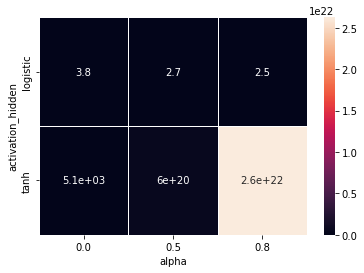

In [83]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='alpha'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='batch_size', ylabel='activation_hidden'>

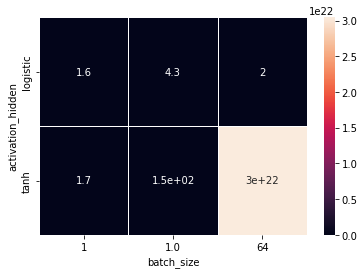

In [84]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='batch_size'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)


<AxesSubplot:xlabel='epochs', ylabel='activation_hidden'>

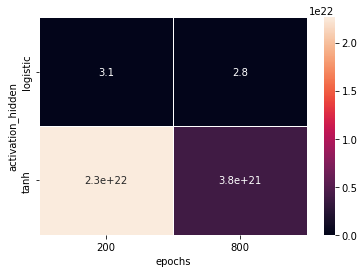

In [85]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='activation_hidden'>

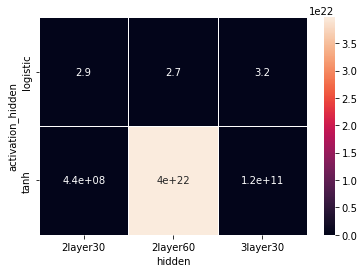

In [86]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='activation_hidden'>

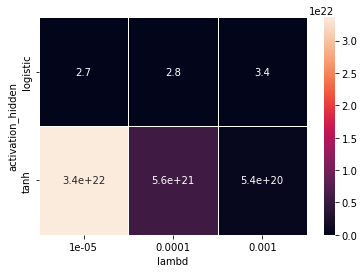

In [87]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='activation_hidden'>

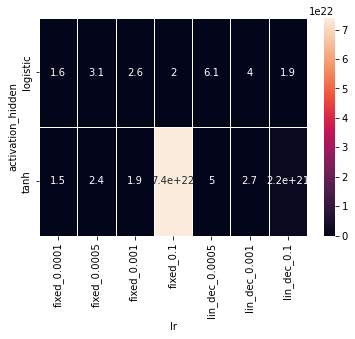

In [88]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='activation_hidden',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='batch_size', ylabel='alpha'>

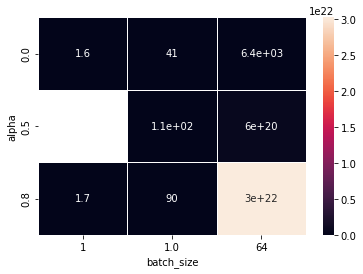

In [89]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='batch_size'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='epochs', ylabel='alpha'>

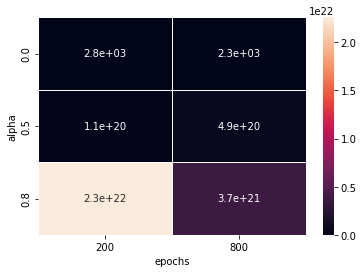

In [90]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='alpha'>

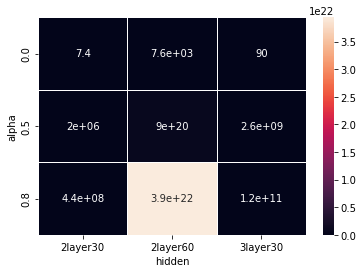

In [91]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='alpha'>

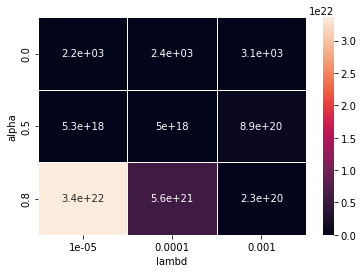

In [92]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='alpha'>

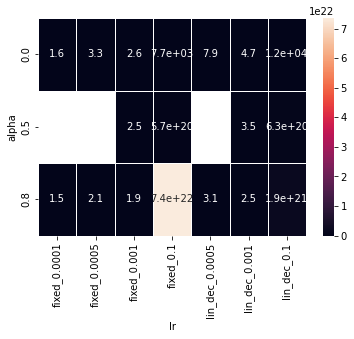

In [93]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='alpha',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

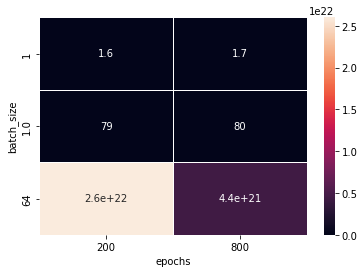

In [94]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='epochs'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='batch_size'>

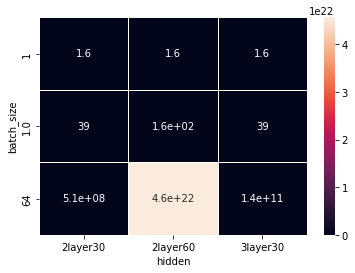

In [95]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='batch_size'>

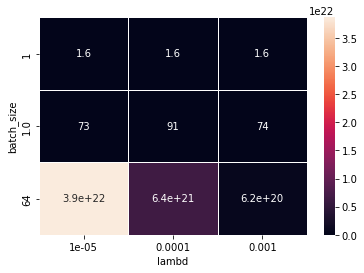

In [96]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='batch_size'>

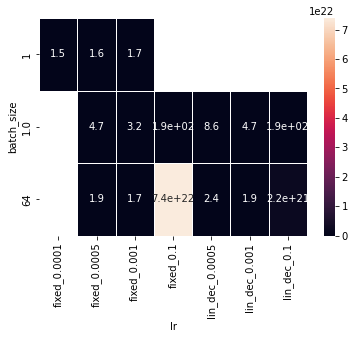

In [97]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='batch_size',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='hidden', ylabel='epochs'>

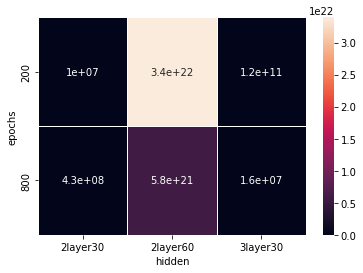

In [98]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='hidden'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='epochs'>

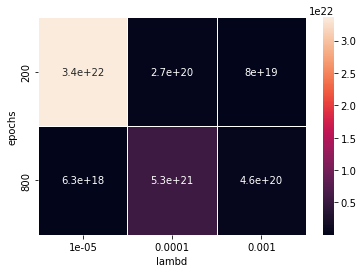

In [99]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='epochs'>

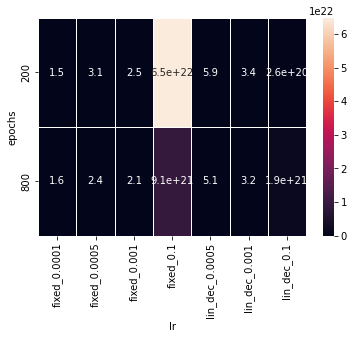

In [100]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='epochs',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='hidden'>

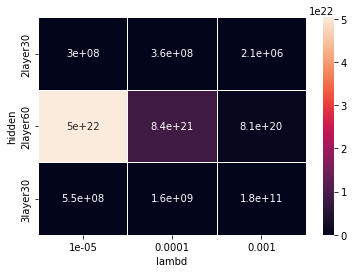

In [101]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='hidden',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lr', ylabel='hidden'>

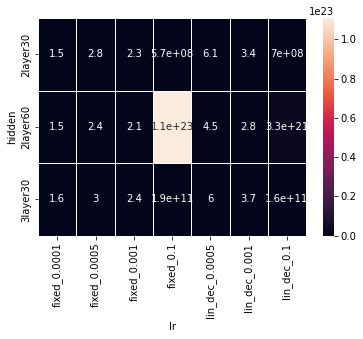

In [102]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='hidden',
        columns='lr'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

<AxesSubplot:xlabel='lambd', ylabel='lr'>

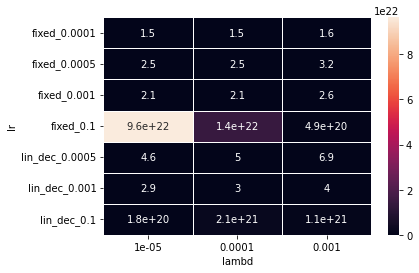

In [103]:
pvt_k = pd.pivot_table(
        params_df, 
        values='val_MEE_mean', 
        index='lr',
        columns='lambd'
    )
sns.heatmap(pvt_k, annot=True, linewidths=.5)

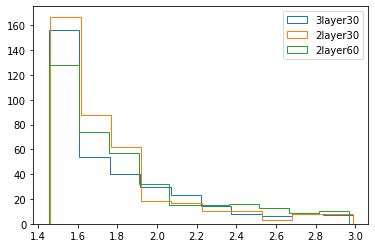

In [104]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='3layer30')], histtype='step', label='3layer30')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='2layer30')], histtype='step', label='2layer30')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['hidden']=='2layer60')], histtype='step', label='2layer60')
plt.legend()

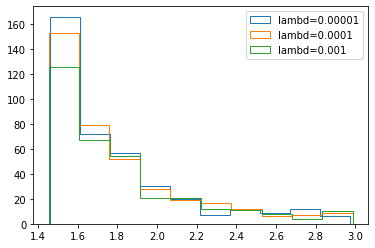

In [105]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.00001)], histtype='step', label='lambd=0.00001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.0001)], histtype='step', label='lambd=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['lambd']==0.001)], histtype='step', label='lambd=0.001')
plt.legend()

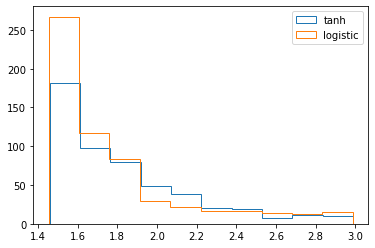

In [106]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['activation_hidden']=='tanh')], histtype='step', label='tanh')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['activation_hidden']=='logistic')], histtype='step', label='logistic')
plt.legend()

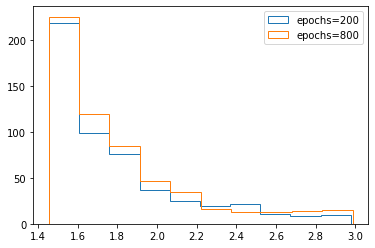

In [107]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['epochs']==200)], histtype='step', label='epochs=200')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['epochs']==800)], histtype='step', label='epochs=800')
plt.legend()

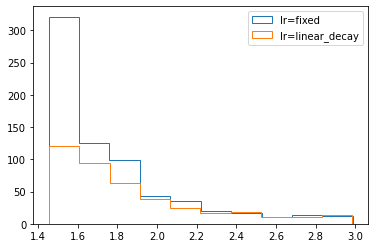

In [108]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate']=='fixed')], histtype='step', label='lr=fixed')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate']=='linear_decay')], histtype='step', label='lr=linear_decay')
plt.legend()

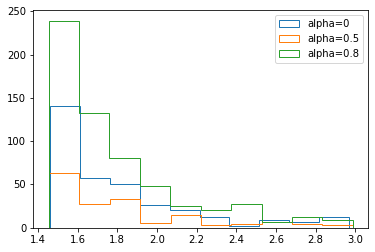

In [109]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0)], histtype='step', label='alpha=0')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0.5)], histtype='step', label='alpha=0.5')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['alpha']==0.8)], histtype='step', label='alpha=0.8')
plt.legend()

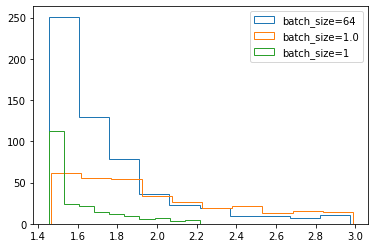

In [110]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='64')], histtype='step', label='batch_size=64')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='1.0')], histtype='step', label='batch_size=1.0')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['batch_size']=='1')], histtype='step', label='batch_size=1')
plt.legend()

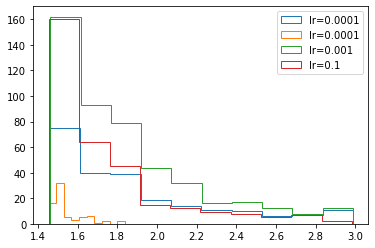

In [111]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.0005)], histtype='step', label='lr=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.0001)], histtype='step', label='lr=0.0001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.001)], histtype='step', label='lr=0.001')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['learning_rate_init']==0.1)], histtype='step', label='lr=0.1')
plt.legend()


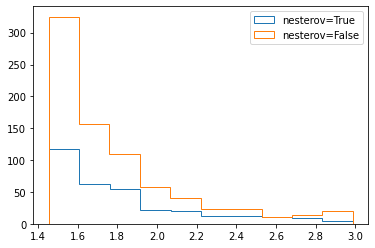

In [112]:
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['nesterov']==True)], histtype='step', label='nesterov=True')
plt.hist(params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3) & (params_df['nesterov']==False)], histtype='step', label='nesterov=False')
plt.legend()

Text(0, 0.5, 'val_MEE_mean')

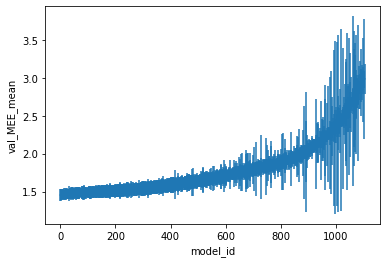

In [113]:
y = params_df['val_MEE_mean'][(params_df['val_MEE_mean']<3)]
yerr = params_df['val_MEE_dev'][(params_df['val_MEE_mean']<3)]
n_models = len(y)
plt.errorbar(x=np.arange(n_models), y=y, yerr=yerr)
plt.xlabel("model_id")
plt.ylabel("val_MEE_mean")

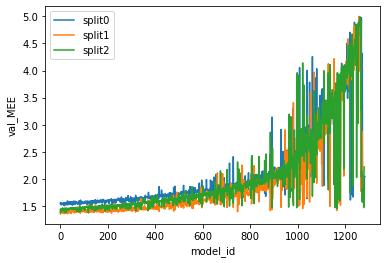

In [114]:
y0=params_df['split0_val_MEE'][(params_df['split0_val_MEE']<5)]
n0=np.arange(len(y0))
y1=params_df['split1_val_MEE'][(params_df['split1_val_MEE']<5)]
n1=np.arange(len(y1))
y2=params_df['split2_val_MEE'][(params_df['split2_val_MEE']<5)]
n2=np.arange(len(y2))

plt.plot(n0, y0, label='split0')
plt.plot(n1, y1, label='split1')
plt.plot(n2, y2, label='split2')
plt.xlabel("model_id")
plt.ylabel("val_MEE")
plt.legend()

Text(0.5, 1.0, 'mean best epoch frequency when 200')

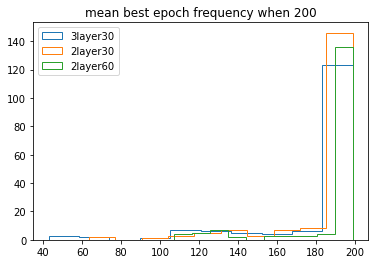

In [121]:
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='3layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='2layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==200)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==200)])/3
		,histtype='step',label='2layer60')
plt.legend()
plt.title('mean best epoch frequency when max 200')

Text(0.5, 1.0, 'mean best epoch frequency when max 800')

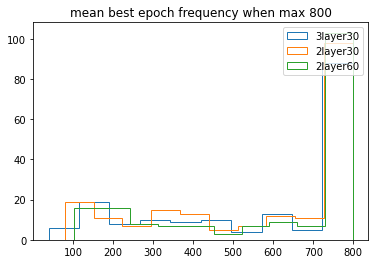

In [122]:
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='3layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='3layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer30') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='2layer30')
plt.hist((params_df['split0_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split0_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split1_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split1_val_MEE']<3) & (params_df['epochs']==800)]+
		params_df['split2_best_epoch'][(params_df['hidden']=='2layer60') & (params_df['split2_val_MEE']<3) & (params_df['epochs']==800)])/3
		,histtype='step',label='2layer60')
plt.legend()
plt.title('mean best epoch frequency when max 800')